## Importera bibliotek och definiera konstanter

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import linregress

# Konstanter
L   = 0.600            # [m]
m   = 0.018            # [kg]
R   = 1.750e-2         # [m]
rho = 1.184            # [kg/m^3]
eta = 1.806e-5         # [Pa*s]
g   = 9.82             # [m/s^2]
pi = np.pi

f = 500                # [Hz]
dt = 1 / f             # [s]
MM_TO_M = 1e-3         #

# OBS: Savitzky-Golay används för att smootha och derivera pendelns läge.
WINDOW_LEN = 51   
POLY_ORDER = 2 
PEAK_DIST = 350       

FILEPATH_INPUT = './../../measurements/pt2/kula4.tsv'

## Läs fil och utför grundläggande databehandling

In [90]:
 # Läs TSV-fil
df = pd.read_csv(
    FILEPATH_INPUT, 
    sep='\t', 
    header=None, 
    skiprows=10, 
    names=['x', 'y', 'z']
)

# Inledande databehandling
# df = df[:]  # Om nödvändigt
df[['x', 'y', 'z']] *= MM_TO_M
df['t'] = dt * df.index

## Hitta vändlägen

In [91]:
df['z_smooth'] = savgol_filter(
    df['z'],
    WINDOW_LEN,
    POLY_ORDER,
    deriv=0,
    delta=dt
)
peak_idxs, _ = find_peaks(df['z_smooth'], distance=PEAK_DIST)
peak_idxs = peak_idxs[0::2]  # Betrakta endast varannan amplitudpunkt fr.o.m. den första

## Hitta x-koordinat för jämvikt och förskjut

In [92]:
mins_idxs, _ = find_peaks(-1 * df['z_smooth'], distance=PEAK_DIST)  # OBS! multiplicera med -1
x_eq = np.mean(df['x'][mins_idxs])  # x_eq har samma index som z_eq dvs z_min
df['x_rel'] = df['x'] - x_eq

## Plotta fart $v(t)$

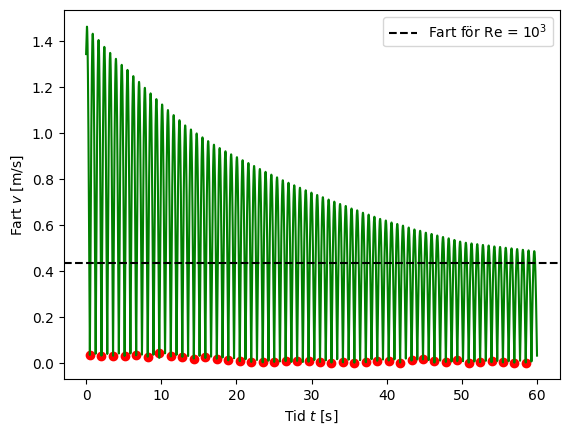

In [93]:
# Beräkna v(t)
vel = savgol_filter(
    df[['x', 'y', 'z']],
    window_length=WINDOW_LEN,
    polyorder=POLY_ORDER,
    deriv=1,                  
    delta=dt,
    axis=0,
)
df['v'] = np.linalg.norm(vel, axis=1)

def v_Re(Re, rho, eta, l):
    """
    Compute the speed corresponding to a given Reynolds number, fluid density, dynamic
    viscosity and characteristic length.
    """
    return Re*eta / (rho*l)

v_min = v_Re(1.0e3, rho, eta, 2*R)

fig0, ax0 = plt.subplots()

# Plotta v(t)
ax0.plot(df['t'], df['v'], color='green')
ax0.axhline(v_min, color='black', linestyle='dashed', label=r'Fart för Re = $10^3$')

ax0.set_xlabel('Tid $t$ [s]')
ax0.set_ylabel('Fart $v$ [m/s]')
ax0.legend()
ax0.scatter(df['t'][peak_idxs], df['v'][peak_idxs], color='red')

# Jämviktslägena (kan tas bort, för eget bruk)
# ax0.scatter(df['t'][mins_idxs], df['v'][mins_idxs], color='blue')  

## Plotta vinkel $\theta(t)$

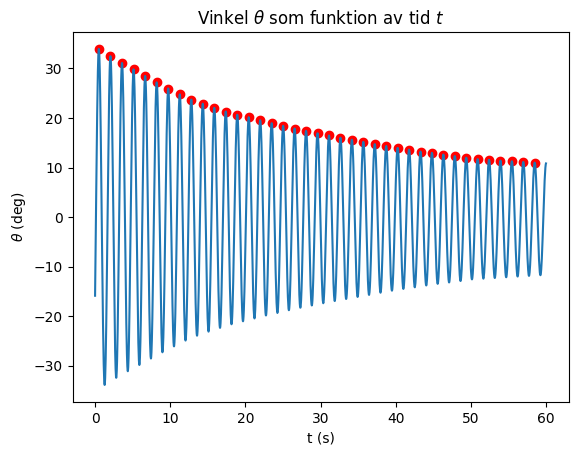

In [94]:
df['th_rad'] = np.arcsin(df['x_rel'] / L)

fig1, ax1 = plt.subplots()
ax1.plot(df['t'], np.degrees(df['th_rad']))
ax1.set_xlabel('t (s)')
ax1.set_ylabel(r'$\theta$ (deg)')
ax1.set_title(r'Vinkel $\theta$ som funktion av tid $t$')
ax1.scatter(df['t'][peak_idxs], np.degrees(df['th_rad'][peak_idxs]), color='red')

## Plotta amplitud $\Theta(t)$

Text(0.5, 1.0, 'Amplitudfunktion mot tid relativt första amplitud')

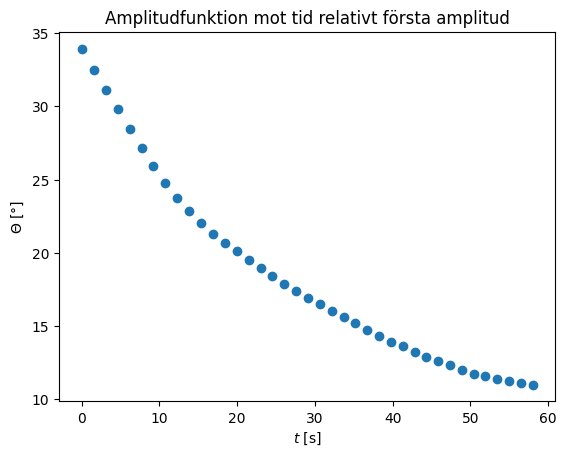

In [95]:
t = df['t'][peak_idxs]
t -= df['t'][peak_idxs[0]]  # Förskjut s.a. t = 0 => Theta[0] 
t = np.array(t)
Theta = np.array((df['th_rad'][peak_idxs]))

# Plotta Theta(t)
fig2, ax2 = plt.subplots()
ax2.scatter(t, np.degrees(Theta))

ax2.set_xlabel(r'$t$ [s]')
ax2.set_ylabel(r'$\Theta$ [°]')
ax2.set_title(r'Amplitudfunktion mot tid relativt första amplitud')


## Hitta gissning och utför ickelinjär regression (kvadratisk dämpning)

\begin{equation}
y \approx \frac{1}{\alpha t + 1/\Theta_0} \implies
1/y \approx \alpha t + 1/\Theta_0
\end{equation}

In [96]:
# Hitta gissning
inv_Theta = 1 / Theta
p0 = linregress(t, inv_Theta)[:2]

# Använd `scipy.optimize.curve_fit` för ickelinjär regression
def quad_model(t, alpha, inv_Theta0):
    return 1 / (alpha*t + inv_Theta0)

popt, pcov = curve_fit(quad_model, t, Theta, p0=p0, bounds=([0, 0], [np.inf, np.inf]))

print(f'Optimal alpha: {popt[0]} s^-1')
print(f'Optimal Theta0: {popt[1]}')

Optimal alpha: 0.060938478939310474 s^-1
Optimal Theta0: 1.6577830217418212


## Plotta $\Theta(t)$ och $\hat \Theta(t)$ tillsammans

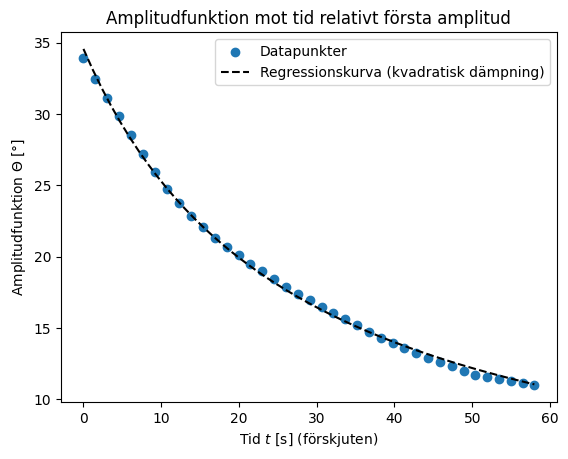

In [97]:
fig3, ax3 = plt.subplots()
ax3.scatter(t, np.degrees(Theta), label=r'Datapunkter')  # Verklig

t_min, t_max = t.min(), t.max()
t_plot = np.linspace(t_min, t_max)

def init_model(alpha, Theta0):
    return lambda t: Theta0 / (1 + alpha*t*Theta0)

model = init_model(popt[0], 1/popt[1])
ax3.plot(t_plot, np.degrees(model(t_plot)), 'k--', label='Regressionskurva (kvadratisk dämpning)')

def init_lin_model(Theta0, gamma):
    return lambda t: Theta0 * np.exp(-gamma*t)

ax3.set_xlabel(r'Tid $t$ [s] (förskjuten)')
ax3.set_ylabel(r'Amplitudfunktion $\Theta$ [°]')
ax3.set_title(r'Amplitudfunktion mot tid relativt första amplitud')
ax3.legend()

In [98]:
def v_reynolds(Re, rho, L, eta):
    return Re * eta / (rho * L)

def flow_regime(v):
    v1 = v_reynolds(1, rho, 2*R, eta)    # Fart vid övergång mellan laminärt och övergångsflöde
    v2 = v_reynolds(1e3, rho, 2*R, eta)  # Fart vid övergång mellan övergångs- och turbulent flöde
    v3 = v_reynolds(2e5, rho, 2*R, eta)  # Fart vid övergång mellan turbulent flöde och superkritiskt Re
    
    assert np.all(v <= v3)
    
    regime = np.empty(v.shape, dtype='U12')
    
    regime[v < v1] = 'laminar'
    regime[(v1 <= v) & (v < v2)] = 'transitional'
    regime[v2 <= v] = 'turbulent'
    
    return regime

num_points_turbulent = df[flow_regime(df['v']) == 'turbulent'].shape[0]
num_points = df.shape[0]
frac_turbulent = num_points_turbulent / num_points

print(f'Andel av svängningsrörelsen där strömningen runt kulan är turbulent: {100 * frac_turbulent:.3f}%')

Andel av svängningsrörelsen där strömningen runt kulan är turbulent: 57.583%


## Logga värdena

In [99]:
print(f'R^2/m = {R**2 / m:.5f}')
print(f'alpha = {popt[0]:.5f}')
print(f'Theta0 = {1 / popt[1]:.5f}')

R^2/m = 0.01701
alpha = 0.06094
Theta0 = 0.60322
